<a href="https://colab.research.google.com/github/vmartinezarias/Curso_Ecologia_Paisaje_y-Ecoacustica/blob/main/Obtener_datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Instalar la API de Google Earth Engine y paquetes requeridos

In [10]:
!pip install earthengine-api geemap
!pip install pycrs


  Preparing metadata (setup.py) ... done
  Created wheel for pycrs: filename=PyCRS-1.0.2-py3-none-any.whl size=32687 sha256=35d02988a5021c6dffbe93f31a4e7c7f7ce0beb9fff4c2630427109cfc0c7317
  Stored in directory: /root/.cache/pip/wheels/47/1d/70/7a5bdf33347e7c75e95b06b1fa38f076a59a9506653cc24aff
Successfully built pycrs


2. Autenticar y autorizar Google Earth Engine.
Para este paso, se requiere tener una cuenta en Google Earth Engine, y un proyecto asociado. El nombre del proyecto, se encuentra arriba de la consola de Google Earth Engine.

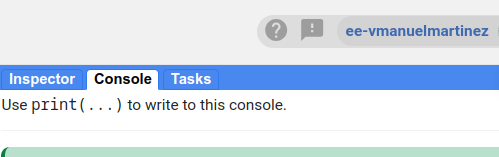

In [4]:
import ee
import geemap

# Trigger the authentication flow for the current user.
ee.Authenticate()
# Initialize the library.
ee.Initialize(project='ee-vmanuelmartinez')

3. Montar Google Drive para Acceder a los archivos necesarios

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


4. Cargar el archivo .shp correspondiente al área de estudio

In [15]:
roi = geemap.shp_to_ee('/content/drive/MyDrive/Curso_Ecologia_Paisaje_Ecoacustica/Area_Estudio.shp')  # Ajustar el nombre del archivo .shp del área de influencia


5. Verificar la carga del área de estudio

In [16]:
# Centrar el mapa en el área de interés
Map = geemap.Map()
Map.centerObject(roi, 10) # Ajusta el nivel de zoom si es necesario
# Añadir el área de interés al mapa
Map.addLayer(roi, {'color': 'red'}, 'Area de Estudio') # Puedes personalizar el color y el nombre
# Mostrar el mapa
Map.addLayerControl()
Map

Map(center=[6.119221122006671, -75.62188674130512], controls=(WidgetControl(options=['position', 'transparent_…

6. Obtención del mapa de coberturas, usando el recurso "Dynamic World" para el área de estudio seleccionada.

In [21]:
# Definir las fechas de inicio y fin
startDate = '2023-05-01'
endDate = '2024-02-03'

# Cargar la colección de imágenes de Dynamic World y filtrar por fecha y región
dw = ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1") \
    .filterDate(startDate, endDate) \
    .filterBounds(roi)

# Crear una imagen de mosaico y recortarla a la región de interés (roi)
dwImage = ee.Image(dw.mosaic()).clip(roi)

# Seleccionar la banda de clasificación 'label'
classification = dwImage.select('label')

# Parámetros de visualización
dwVisParams = {
    'min': 0,
    'max': 8,
    'palette': ['419BDF', '397D49', '88B053', '7A87C6',
                'E49635', 'DFC35A', 'C4281B', 'A59B8F',
                'B39FE1']
}

# Mostrar la imagen clasificada en el mapa interactivo de geemap
Map = geemap.Map()
Map.centerObject(roi)
Map.addLayer(classification, dwVisParams, 'Classified Image')

# Crear una leyenda personalizada
legend_dict = {
    'Agua': '419BDF',
    'Árboles': '397D49',
    'Césped': '88B053',
    'Vegetación inundada': '7A87C6',
    'Cultivos': 'E49635',
    'Matorral y arbustos': 'DFC35A',
    'Construido': 'C4281B',
    'Desnudo': 'A59B8F',
    'Nieve y hielo': 'B39FE1'
}

# Agregar la leyenda al mapa
Map.add_legend(title="Leyenda de Cobertura", legend_dict=legend_dict)
Map


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

7. Exportar a Google Drive el Ráster, con EPSG:32618

In [22]:
# Exportar la imagen a Google Drive con la configuración deseada
task = ee.batch.Export.image.toDrive(**{
    'image': classification.reproject(crs='EPSG:32618', scale=10),  # Proyección y escala deseadas
    'description': 'Coberturas_DW',
    'folder': 'Curso_Ecologia_Paisaje_Ecoacustica',  # Nombre de la carpeta de destino en tu Drive (asegúrate de que existe)
    'fileNamePrefix': 'Coberturas_DW',  # Nombre del archivo de salida
    'region': roi.geometry().bounds().getInfo()['coordinates'],
    'scale': 10,
    'maxPixels': 1e13
})

task.start()
print("La exportación ha comenzado. Revisa en https://code.earthengine.google.com/tasks para verificar el estado.")


La exportación ha comenzado. Revisa en https://code.earthengine.google.com/tasks para verificar el estado.
